<a href="https://colab.research.google.com/github/Inno732/Defi_IA_1_2023_2024/blob/main/3_Input_classification_Fire_detection_2023_2024_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [ ]:
!nvidia-smi
!rm -rf sample_data

Fri Oct 20 13:15:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
import math
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)

Tensorflow version: 2.13.0


#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [ ]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [ ]:
!rm -rf sample_data
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/QP7FoyttxJgS8Cj/download/small.zip
! unzip small.zip -d 'bases'
! rm small.zip

--2023-10-20 13:15:27--  https://nextcloud.ig.umons.ac.be/s/QP7FoyttxJgS8Cj/download/small.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487265626 (465M) [application/zip]
Saving to: ‘small.zip’

small.zip           100%[===================>] 464.69M  23.9MB/s    in 21s     

2023-10-20 13:15:49 (22.2 MB/s) - ‘small.zip’ saved [487265626/487265626]

Archive:  small.zip
   creating: bases/small/
   creating: bases/small/fire/
  inflating: bases/small/fire/00000000.jpg  
  inflating: bases/small/fire/00000001.jpg  
  inflating: bases/small/fire/00000003.jpg  
  inflating: bases/small/fire/00000004.jpg  
  inflating: bases/small/fire/00000005.jpg  
  inflating: bases/small/fire/00000006.jpg  
  inflating: bases/small/fire/00000007.jpg  
  inflating: bases/small/fire/00000008.jpg  
  inflating: bas

#**4. Téléchargement des données de test "Test Dataset"**

In [ ]:
!rm -rf sample_data
!wget https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
!unzip test.zip -d 'bases'
!rm test.zip

--2023-10-20 13:15:55--  https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57038454 (54M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  54.40M  10.9MB/s    in 5.6s    

2023-10-20 13:16:01 (9.78 MB/s) - ‘test.zip’ saved [57038454/57038454]

Archive:  test.zip
   creating: bases/test/
   creating: bases/test/fire/
  inflating: bases/test/fire/F_1001.jpg  
  inflating: bases/test/fire/F_2062.jpg  
  inflating: bases/test/fire/F_2063.jpg  
  inflating: bases/test/fire/F_2064.jpg  
  inflating: bases/test/fire/F_2066.jpg  
  inflating: bases/test/fire/F_2067.jpg  
  inflating: bases/test/fire/F_2068.jpg  
  inflating: bases/test/fire/F_2070.jpg  
  inflating: bases/test/fire/F_2071.jpg  
  inflat

#**5. Création du fichier de labels "classes.txt"**

In [ ]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [ ]:
nb_classes = 3
batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=10 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "bases"
input_dim=299 #@param [224,299] {type:"raw"}
dataset_name='small' #@param ["small","DB1","DB2","DB3"]
train_dataset = os.path.join('bases/', dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join('bases/', test_name)
classes_path = "classes.txt"
classifier = "Xception" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [ ]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size= (299, 299),      # Taille des images d'entrée
	batch_size= batch_size,      # Taille du mini-batch
  label_mode= 'categorical'    # Conversion au format One-Hot
)                             # Generates a 'tf.data.Dataset' from image files in a directory (train_dataset)

Found 791 files belonging to 3 classes.
Using 633 files for training.


#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot, jeu "validation")**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)
print(val_ds.class_names)

Found 791 files belonging to 3 classes.
Using 158 files for validation.
['fire', 'no_fire', 'start_fire']


# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [ ]:
model_xception = Xception(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# create a custom top classifier
x = model_xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs = model_xception.inputs, outputs=predictions)


# **10.1 Analyser/visualiser l'architecture de votre modèle avec la fonction summary()**

# **11. Geler puis dégeler les poids des premières couches**

In [ ]:
for layer in model.layers:
        layer.trainable = True
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [ ]:
# recompiler le modèle
#??????????????????????????????????????????????????????????????????????????????????????????????
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

# **12. Entraîner le modèle**

In [ ]:
history=model.fit(
    train_ds,
#    steps_per_epoch=math.ceil(len(train_ds)),
    epochs=epochs,
    validation_data=val_ds,
 #   validation_steps=math.ceil(len(val_ds)),
#    verbose=1
)
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

Epoch 1/10
80/80 [==============================] - 36s 294ms/step - loss: 1.0111 - categorical_accuracy: 0.5624 - val_loss: 0.9580 - val_categorical_accuracy: 0.6646
Epoch 2/10
80/80 [==============================] - 23s 277ms/step - loss: 0.9317 - categorical_accuracy: 0.6572 - val_loss: 0.8894 - val_categorical_accuracy: 0.6962
Epoch 3/10
80/80 [==============================] - 25s 291ms/step - loss: 0.8536 - categorical_accuracy: 0.7235 - val_loss: 0.8285 - val_categorical_accuracy: 0.7215
Epoch 4/10
80/80 [==============================] - 25s 294ms/step - loss: 0.8000 - categorical_accuracy: 0.7188 - val_loss: 0.7715 - val_categorical_accuracy: 0.7468
Epoch 5/10
80/80 [==============================] - 23s 269ms/step - loss: 0.7357 - categorical_accuracy: 0.7472 - val_loss: 0.7155 - val_categorical_accuracy: 0.7658
Epoch 6/10
80/80 [==============================] - 24s 284ms/step - loss: 0.6945 - categorical_accuracy: 0.7567 - val_loss: 0.6674 - val_categorical_accuracy: 0.784

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [ ]:
model.save("model_xception.h5")
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

#**14. Afficher des courbes d'entrainement/validation**

Text(0, 0.5, 'loss')

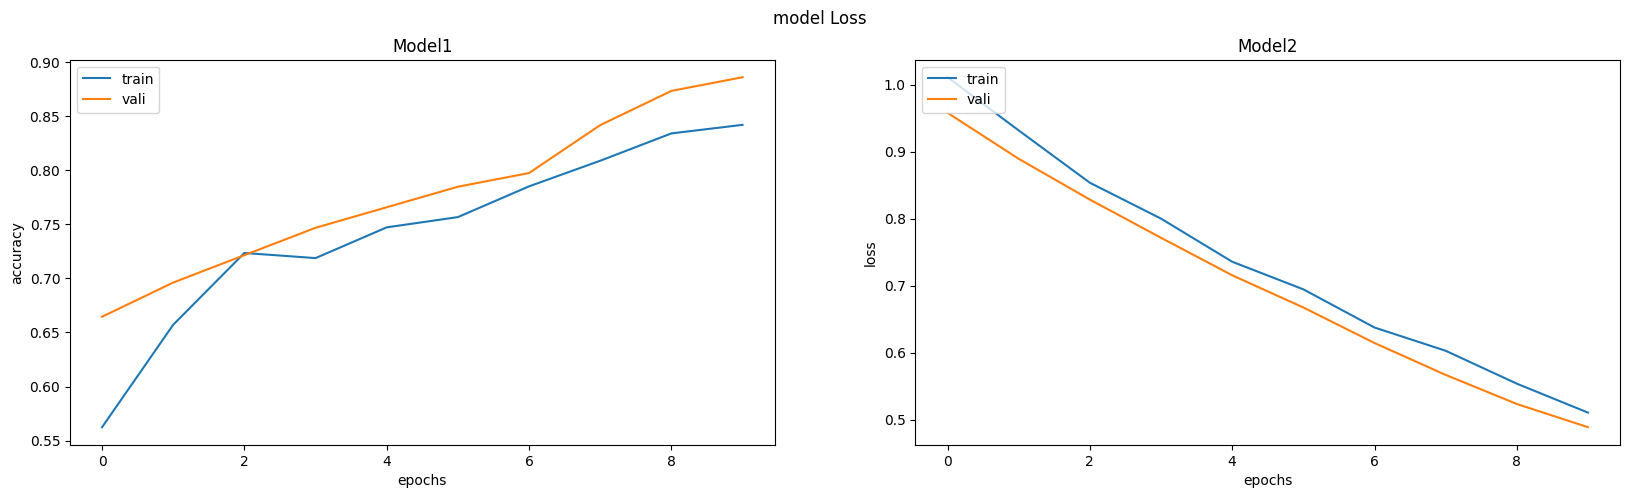

In [ ]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle('model Loss')

axs[0].plot(history.history["categorical_accuracy"])
axs[0].plot(history.history["val_categorical_accuracy"])
axs[0].legend(['train', 'vali'], loc='upper left')
axs[0].set_title('Model1')
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("accuracy")

axs[1].plot(history.history["loss"])
axs[1].plot(history.history["val_loss"])
axs[1].legend(['train', 'vali'], loc='upper left')
axs[1].set_title('Model2')
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("loss")
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

# **15. Créer le jeu de données de test**

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset,
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)

#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

Found 300 files belonging to 3 classes.


# **16. Evaluer le modèle avec ce jeu de données de test avec la fonction evaluate()**

In [ ]:
test = model.evaluate(test_ds)
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

38/38 [==============================] - 3s 64ms/step - loss: 0.9379 - categorical_accuracy: 0.5567


#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [ ]:
files.upload()

Saving fire.jpg to fire.jpg


{'fire.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x12\x15\x12\x12\x12\x15\x15\x15\x15\x17\x17\x15\x17\x15\x15\x17\x15\x15\x15\x17\x17\x18\x17\x17\x17\x17\x15\x17\x15\x18\x1d( \x18\x1a%\x1d\x15\x15!1!%)+...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1a\x10\x10\x1a-&\x1f%--------------------------------------------------\xff\xc0\x00\x11\x08\x00\xdc\x00\xe5\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x01\x04\x05\x00\x06\x07\xff\xc4\x00?\x10\x00\x02\x01\x02\x04\x03\x05\x04\x07\x07\x04\x02\x03\x00\x00\x00\x01\x02\x00\x03\x11\x04\x12!1\x05AQ\x13"aq\x81\x062\x91\xa1Rr\xb1\xb2\xc1\xd1\xf0\x07\x14#BC\x82\xa23b\xe1\xf1\x92\xc2\x154c\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x00\x05\x06\xff\xc4\x002\x11\x00\x02\x02\x01\x03\x02\x04\x05\x04\x02\x02\x03\x01\x00\x00\x00\x00\x01\x02\x11\x03\x

1/1 [==============================] - 1s 852ms/step
Class Name : fire --- Class Probability: 85.33%
Class Name : no_fire --- Class Probability: 7.29%
Class Name : start_fire --- Class Probability: 7.38%


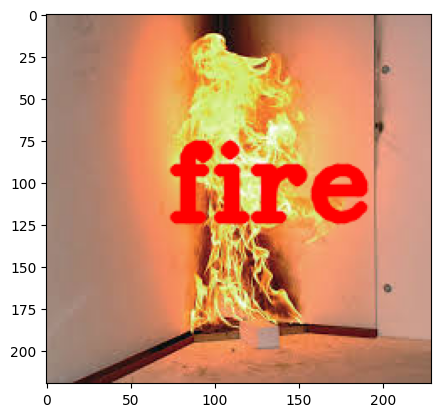

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()